***Imports***

In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import cv2
from google.colab import drive
from torchsummary import summary
import torchvision.models as models
from torchvision.models import VGG16_Weights
from torchvision import transforms
from torch import nn
import torch
import os
from torcheval.metrics import TopKMultilabelAccuracy, MultilabelAccuracy
import gzip
import pickle as pkl
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.neighbors import KDTree
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


***Parameters***

In [4]:
NUM_ATTR = 300
NUM_CLASS = 15
BATCH_SIZE = 128
EPOCHS = 65
LR = 5e-5
SHUFFLE = False
train_classes = ['arm','boy','bread','chicken','child','computer','ear','house','leg','sandwich'
,'television','truck','vehicle','watch','woman']
zsl_classes = ['car','food','hand','man','neck']
WORD2VECPATH = '/content/drive/MyDrive/class_vectors.npy'
DATAPATH = '/content/drive/MyDrive/zeroshot_data.pkl'
MODELPATH = ''
np.random.seed(123)

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

***Data Preprocessing***

In [6]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [7]:
def load_data():
  with gzip.GzipFile(DATAPATH, 'rb') as infile:
    data = pkl.load(infile)

  label_encoder = LabelEncoder()
  label_encoder.fit(train_classes)

  training_data = [instance for instance in data if instance[0] in train_classes]
  zero_shot_data = [instance for instance in data if instance[0] not in train_classes]

  #shuffle training data
  np.random.shuffle(training_data)

  train_size = 300
  train_data = list()
  valid_data = list()

  for class_label in train_classes:
    ct = 0
    for instance in training_data:
      if instance[0] == class_label:
        if ct < train_size:
          train_data.append(instance)
          ct += 1
          continue
        valid_data.append(instance)

  np.random.shuffle(train_data)
  np.random.shuffle(valid_data)

  train_data = [(instance[1], to_categorical(label_encoder.transform([instance[0]]), num_classes = NUM_CLASS)) for instance in train_data]
  valid_data = [(instance[1], to_categorical(label_encoder.transform([instance[0]]), num_classes = NUM_CLASS)) for instance in valid_data]

  x_train, y_train = zip(*train_data)
  x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
  x_train = normalize(x_train, norm='l2')

  x_valid, y_valid = zip(*valid_data)
  x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
  x_valid = normalize(x_valid, norm='l2')

  y_zsl, x_zsl = zip(*zero_shot_data)
  x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
  x_zsl = normalize(x_zsl, norm='l2')

  print('---- Data loading is completed')
  return (x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl)





***Building Model***

In [8]:
def custom_kernel_init(m):
    if type(m) == nn.Linear and m.in_features == NUM_ATTR and m.out_features == NUM_CLASS:
      np_load_old = np.load
      np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
      class_vectors = np.load(WORD2VECPATH)
      np.load = np_load_old
      training_vectors = sorted([(label, vec) for (label, vec) in class_vectors if label in train_classes], key=lambda x: x[0])
      classnames, vectors = zip(*training_vectors)
      vectors = np.asarray(vectors, dtype=np.float)
      vectors = torch.from_numpy(vectors)
      for i in range(NUM_CLASS):
        for k in range(NUM_ATTR):
          m.weight.data[i][k].fill_(vectors[i][k])

In [9]:
class ZeroShotLearning(torch.nn.Sequential):

  def __init__(self):
    super(ZeroShotLearning, self).__init__()

    self.linear1 = torch.nn.Linear(4096, 1024)
    self.activation1 = torch.nn.ReLU()
    self.bn1 = torch.nn.BatchNorm1d(1024)
    self.dropout1 = torch.nn.Dropout(p = 0.8)
    self.linear2 = torch.nn.Linear(1024, 512)
    self.dropout2 = torch.nn.Dropout(p = 0.5)
    self.linear3 = torch.nn.Linear(512, NUM_ATTR)
    self.activation2 = torch.nn.ReLU()
    self.linear4 = torch.nn.Linear(NUM_ATTR, NUM_CLASS)
    self.softmax1 = torch.nn.Softmax(dim=1)

  def forward(self,x):
    x = self.linear1(x)
    x = self.activation1(x)
    x = self.bn1(x)
    x = self.dropout1(x)
    x = self.linear2(x)
    x = self.dropout2(x)
    x = self.linear3(x)
    x = self.activation2(x)
    x = self.linear4(x)
    x = self.softmax1(x)
    return x


In [10]:
def build_model():
  model = ZeroShotLearning()
  print("---- The model building is completed")
  return model

***Image Embeddings***

In [11]:
def get_vgg16_model():

  model = models.vgg16(pretrained = True)
  model = nn.Sequential(*list(model.children())[:-2]) #Pop the last 2 layers
  summary(model, (3,224,224))
  return model

In [12]:
#Returns the features of a given image. Uses VGG16 as extractor
def get_features(model, cropped_image):
  weights = VGG16_Weights.DEFAULT
  preprocess = weights.transforms()
  img_transformed = preprocess(cropped_image)
  features = model(img_transformed)
  return features

****Training****

In [13]:
def load_model(model_path):
  model = torch.load(model_path)
  return model

In [14]:
def save_model(model, model_path):
  #if not os.path.exists(model_path):
    #os.makedirs(model_path)
  torch.save(model, model_path)
  return

In [15]:
def train_model(model, train_data, valid_data):

  #training_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = TRAIN_SHUFFLE)
  #validation_loader = torch.utils.data.DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = VAL_SHUFFLE)

  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = LR)
  loss_fn = nn.CrossEntropyLoss()

  h_train_acc = list()
  h_val_acc = list()
  h_epoch = list()
  h_train_loss = list()
  h_val_loss = list()

  for epoch in range(EPOCHS):

    x_train, y_train = train_data
    if SHUFFLE:
      x_train, y_train = shuffle(x_train, y_train)

    x_valid, y_valid = valid_data

    x_train_len = len(x_train)

    model.train()
    running_loss = 0
    last_loss = 0
    y_pred = []
    number_of_batches = (x_train_len // BATCH_SIZE) + 1

    for batch_num in range(number_of_batches):
      startIndex = batch_num * BATCH_SIZE
      endIndex = (batch_num * BATCH_SIZE + BATCH_SIZE)
      if endIndex > x_train_len:
        endIndex = x_train_len - 1

      inputs, labels = x_train[startIndex:endIndex], y_train[startIndex:endIndex]

      optimizer.zero_grad() #Clears x.grad for every parameter x in the optimizer. It is important to call this before loss.backward().
      y_pred = model(torch.from_numpy(inputs))
      labels = torch.from_numpy(labels.astype('float'))
      loss = loss_fn(y_pred,labels)

      loss.backward() #Computes dloss/dx for every parameter x

      optimizer.step() #Updates the value of x using the gradient x.grad

      running_loss += loss.item()

      metric = MultilabelAccuracy()
      acc = MultilabelAccuracy()
      metric.update(y_pred, labels)
      acc = metric.compute().item()

    model.eval()

    last_loss = running_loss / number_of_batches

    running_vloss = 0
    x_valid_len = len(x_valid)
    number_of_batches = (x_valid_len // BATCH_SIZE) + 1
    with torch.no_grad():
        for batch_num in range(number_of_batches):

          startIndex = batch_num * BATCH_SIZE
          endIndex = (batch_num * BATCH_SIZE + BATCH_SIZE)
          if endIndex > x_valid_len:
            endIndex = x_valid_len - 1

          vinputs, vlabels = x_valid[startIndex:endIndex], y_valid[startIndex:endIndex]
          voutputs = model(torch.from_numpy(vinputs))
          vlabels = torch.from_numpy(vlabels.astype('float'))
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

          vacc = MultilabelAccuracy()
          metric.update(voutputs, vlabels)
          vacc = metric.compute().item()

    avg_vloss = running_vloss / (batch_num+1)

    h_epoch.append(epoch+1)
    h_train_loss.append(last_loss)
    h_val_loss.append(avg_vloss)
    h_train_acc.append(acc)
    h_val_acc.append(vacc)
    print('Epoch={} train_loss={} valid_loss={} train accuracy={} val accuracy={}'.format(epoch,last_loss, avg_vloss,acc, vacc))

  print('Training is completed')
  return (h_epoch, h_train_loss, h_val_loss, h_train_acc, h_val_acc)



***Evaluation Graphs***

In [16]:
def draw_graphs(history):
    h_epoch, h_train_loss, h_val_loss, h_train_acc, h_val_acc = history

    #Train Loss vs Validation Loss
    plt.plot(h_epoch, h_train_loss, 'r--')
    plt.plot(h_epoch, h_val_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    #Train Accuracy vs Validation Accuracy
    plt.plot(h_epoch, h_train_acc, 'r--')
    plt.plot(h_epoch, h_val_acc, 'b-')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


***Evaluation***

---- Data loading is completed
---- The model building is completed


<ipython-input-8-0fd653740b69>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vectors = np.asarray(vectors, dtype=np.float)


Epoch=0 train_loss=2.6514932872762915 valid_loss=2.702721618943744 train accuracy=0.15789473056793213 val accuracy=0.001985440030694008
Epoch=1 train_loss=2.5502307470874284 valid_loss=2.608924748590364 train accuracy=0.31578946113586426 val accuracy=0.07081402838230133
Epoch=2 train_loss=2.483165253019124 valid_loss=2.4279115766005974 train accuracy=0.31578946113586426 val accuracy=0.33620119094848633
Epoch=3 train_loss=2.4181725716025007 valid_loss=2.3802662909378314 train accuracy=0.4736842215061188 val accuracy=0.39311712980270386
Epoch=4 train_loss=2.376394130006345 valid_loss=2.356174719279691 train accuracy=0.5263158082962036 val accuracy=0.41826605796813965
Epoch=5 train_loss=2.353428875775572 valid_loss=2.3395261790766013 train accuracy=0.5263158082962036 val accuracy=0.4315023124217987
Epoch=6 train_loss=2.326193760761893 valid_loss=2.3223738970811523 train accuracy=0.4736842215061188 val accuracy=0.4500330984592438
Epoch=7 train_loss=2.3040889143012464 valid_loss=2.301256814

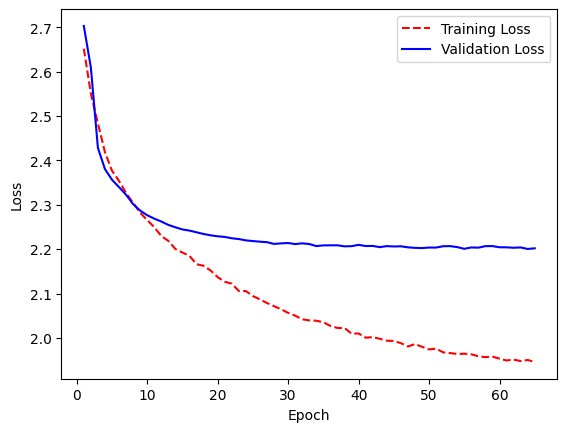

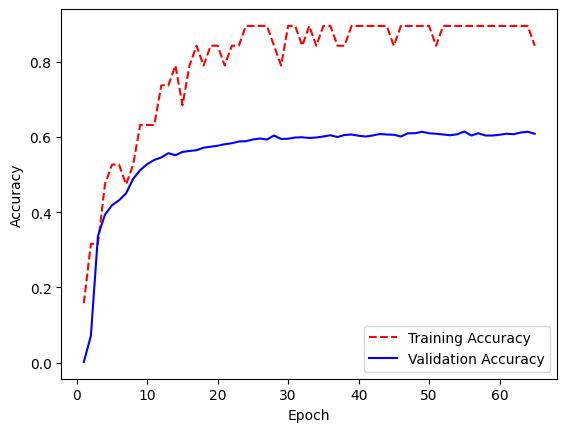

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       4,195,328
              ReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 300]         153,900
              ReLU-8                  [-1, 300]               0
            Linear-9                   [-1, 15]           4,515
          Softmax-10                   [-1, 15]               0
Total params: 4,880,591
Trainable params: 4,876,076
Non-trainable params: 4,515
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 18.62
Es

In [17]:
(x_train, x_valid, x_zsl), (y_train, y_valid, y_zsl) = load_data()
model = build_model()

model.linear4.weight.requires_grad = False
model.linear4.bias.requires_grad = False
model.apply(custom_kernel_init)

history = train_model(model, (x_train,y_train), (x_valid,y_valid))
model = model.to('cuda')
draw_graphs(history)
summary(model, input_size=(4096,))

***Save Model***

In [18]:
save_model(model, '/content/drive/MyDrive/zsl_model.pt')

***Prediction***

In [19]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
class_vectors       = sorted(np.load(WORD2VECPATH), key=lambda x: x[0])
np.load = np_load_old
classnames, vectors = zip(*class_vectors)
classnames          = list(classnames)
vectors             = np.asarray(vectors, dtype=np.float)

model = nn.Sequential(*list(model.children())[:-2])
model = model.to('cuda')
print(summary(model, input_size=(4096,)))

tree = KDTree(vectors)
pred_zsl = model(torch.from_numpy(x_zsl).to('cuda'))
model = model.to('cuda')
top5, top3, top1 = 0,0,0
for i, pred in enumerate(pred_zsl):
  pred = pred.cpu().detach().numpy()
  pred = np.expand_dims(pred, axis=0)
  dist_5, index_5 = tree.query(pred, k = 5)
  pred_labels = [classnames[index] for index in index_5[0]]
  true_label = y_zsl[i]

  if true_label in pred_labels:
    top5 += 1

  if true_label in pred_labels[:3]:
    top3 += 1

  if true_label in pred_labels[0]:
    top1 += 1

print()
print('Zero Shot Learning Scores: ')
print("-> Top-5 Accuracy: %.2f" % (top5 / float(len(x_zsl))))
print("-> Top-3 Accuracy: %.2f" % (top3 / float(len(x_zsl))))
print("-> Top-1 Accuracy: %.2f" % (top1 / float(len(x_zsl))))


<ipython-input-19-2767e62009a9>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vectors             = np.asarray(vectors, dtype=np.float)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       4,195,328
              ReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 300]         153,900
              ReLU-8                  [-1, 300]               0
Total params: 4,876,076
Trainable params: 4,876,076
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 18.60
Estimated Total Size (MB): 18.66
----------------------------------------------------------------
None

Zero Shot Learning Scores: 
->